# In this notebook, I will import the csv I created of my results from the Google API and use the gathered latitude and longitude to turn it into a geodataframe. From there, I will merge it with the Davidson Census Tract geojson and use that to create some map visualizations. 

In [1]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point, LineString
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from itertools import combinations
%matplotlib inline

In [2]:
businesses = pd.read_csv('../data/businesses_in_pred_black_tracts_2.csv')
businesses.head()

,Unnamed: 0,name,type,latitude,longitude,tract
0,0,Shell,gas_station,36.252069,-86.829760,census_tract_10105
1,1,Cenex KCK's,gas_station,36.279847,-86.873683,census_tract_10105
2,2,Kroger Fuel Center,gas_station,36.210674,-86.838564,census_tract_10105
3,3,Brenda's Corner Market,convenience_store,36.280015,-86.873743,census_tract_10105
4,4,Kwik Sak,gas_station,36.218140,-86.836695,census_tract_10105


In [3]:
businesses.type.value_counts()

restaurant                388
bar                       197
hospital                  179
point_of_interest         148
gas_station               110
meal_takeaway              70
clothing_store             69
cafe                       38
meal_delivery              32
night_club                 30
convenience_store          26
grocery_or_supermarket     16
supermarket                14
shoe_store                 13
bakery                     12
drugstore                  12
pharmacy                    7
tourist_attraction          6
beauty_salon                4
home_goods_store            4
jewelry_store               3
lodging                     3
hair_care                   3
book_store                  2
art_gallery                 2
doctor                      2
health                      2
parking                     1
laundry                     1
hardware_store              1
car_wash                    1
department_store            1
atm                         1
shopping_m

In [4]:
businesses['geometry'] = businesses.apply(lambda x: Point((x.longitude, 
                                                         x.latitude)), 
                                        axis=1) #code to create the geometry field
businesses.head(3)

,Unnamed: 0,name,type,latitude,longitude,tract,geometry
0,0,Shell,gas_station,36.252069,-86.829760,census_tract_10105,POINT (-86.8297597 36.2520693)
1,1,Cenex KCK's,gas_station,36.279847,-86.873683,census_tract_10105,POINT (-86.873683 36.279847)
2,2,Kroger Fuel Center,gas_station,36.210674,-86.838564,census_tract_10105,POINT (-86.8385638 36.2106742)


## Now I will read in the Davidson Census Tract geojson file and inspect it. 

In [5]:
davidson_tracts = gpd.read_file('../data/davidson_tracts_pred_black.geojson')
davidson_tracts.head(3)

,geoid,name,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,nativeamer,nativeam_1,asian_alon,asian_al_1,hawaiian_p,hawaiian_1,other_alon,other_al_1,two_or_mor,two_or_m_1,two_includ,two_incl_1,two_exclud,two_excl_1,white_pct,black_af_p,nativeam_2,asian_al_2,hawaiian_2,other_al_2,two_or_m_2,centroid,radius,buffer,geometry
0,14000US47037010105,"Census Tract 101.05, Davidson, TN",4435.0,328.0,967.0,174.0,3317.0,354.0,0.0,12.0,0.0,12.0,0.0,12.0,49.0,78.0,102.0,85.0,12.0,20.0,90.0,82.0,0.218038,0.747914,0.0,0.000000,0.0,0.011048,0.022999,POINT (-86.85387694867056 36.24885011739272),3729.841782,4534.841782,"POLYGON ((-86.89144 36.26205, -86.89100 36.262..."
1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.0,0.003827,0.0,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
2,14000US47037010903,"Census Tract 109.03, Davidson, TN",5863.0,648.0,503.0,195.0,4741.0,539.0,0.0,17.0,14.0,17.0,0.0,17.0,503.0,454.0,102.0,67.0,0.0,17.0,102.0,67.0,0.085792,0.808630,0.0,0.002388,0.0,0.085792,0.017397,POINT (-86.76382269139667 36.24932859655561),1911.288764,2716.288764,"POLYGON ((-86.78518 36.23812, -86.78502 36.239..."


In [6]:
davidson_tracts.crs #checking the crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

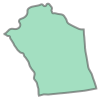

In [7]:
davidson_tracts.loc[0, 'geometry']

<AxesSubplot:>

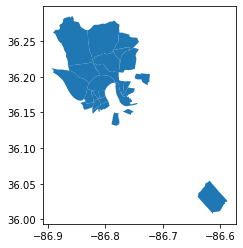

In [8]:
davidson_tracts.plot()

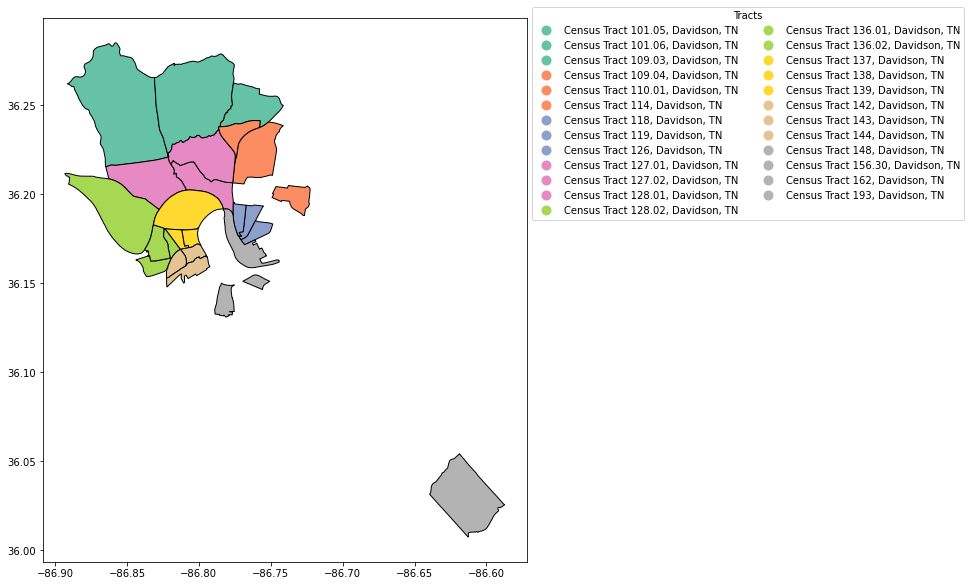

In [9]:
#geopandas handles legend styling if you pass a dict of keywords

leg_kwds = {'title': 'Tracts', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 2}

davidson_tracts.plot(column = 'name', figsize=(10, 10),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'Set2')
plt.show()

## Now we will make the businesses geodataframe using the Davidson Tracts crs.

In [10]:
businesses_geo = gpd.GeoDataFrame(businesses, #param 1: dataframe
                           crs = davidson_tracts.crs, #param 2: crs needed
                           geometry = businesses['geometry']) #param 3: column to use for the geometry field

In [11]:
type(businesses_geo) #Checking the datatype

geopandas.geodataframe.GeoDataFrame

## Now I'll do a spatial join to keep only the businesses that are inside the Davidson tracts, since in a previous workbook when I ran the API, I included a half mile buffer. So I want to get rid of any businesses that may have inadvertantly made it in the dataframe because of the buffer. 

### At this time, I want to keep all info. So I'll just perform the join without dropping any columns

In [12]:
businesses_by_tract = gpd.sjoin(businesses_geo, davidson_tracts, op = 'within')

In [13]:
businesses_by_tract

,Unnamed: 0,name_left,type,latitude,longitude,tract,geometry,index_right,geoid,name_right,total_pop,total_pop_,white_alon,white_al_1,black_afri,black_af_1,nativeamer,nativeam_1,asian_alon,asian_al_1,hawaiian_p,hawaiian_1,other_alon,other_al_1,two_or_mor,two_or_m_1,two_includ,two_incl_1,two_exclud,two_excl_1,white_pct,black_af_p,nativeam_2,asian_al_2,hawaiian_2,other_al_2,two_or_m_2,centroid,radius,buffer
0,0,Shell,gas_station,36.252069,-86.829760,census_tract_10105,POINT (-86.82976 36.25207),1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.000000,0.003827,0.000000,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329
9,9,Fontanel,lodging,36.256853,-86.829741,census_tract_10105,POINT (-86.82974 36.25685),1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.000000,0.003827,0.000000,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329
10,10,Vintage Creek Boutique,point_of_interest,36.264939,-86.830643,census_tract_10105,POINT (-86.83064 36.26494),1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.000000,0.003827,0.000000,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329
16,16,Kingdom Cafe & Grill,restaurant,36.247735,-86.826507,census_tract_10105,POINT (-86.82651 36.24774),1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.000000,0.003827,0.000000,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329
31,31,Whites Creek Wellness & Rehabilitation Center,hospital,36.238445,-86.802270,census_tract_10106,POINT (-86.80227 36.23844),1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.000000,0.003827,0.000000,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329
35,35,Cintas Uniform Services,point_of_interest,36.245480,-86.783026,census_tract_10106,POINT (-86.78303 36.24548),1,14000US47037010106,"Census Tract 101.06, Davidson, TN",3397.0,288.0,1020.0,184.0,2192.0,207.0,0.0,12.0,13.0,17.0,0.0,12.0,136.0,215.0,36.0,39.0,0.0,12.0,36.0,39.0,0.300265,0.645275,0.000000,0.003827,0.000000,0.040035,0.010598,POINT (-86.80361436262159 36.25371488856965),3190.149329,3995.149329
2,2,Kroger Fuel Center,gas_station,36.210674,-86.838564,census_tract_10105,POINT (-86.83856 36.21067),11,14000US47037012801,"Census Tract 128.01, Davidson, TN",5616.0,675.0,711.0,364.0,4564.0,685.0,0.0,17.0,0.0,17.0,0.0,17.0,109.0,137.0,232.0,252.0,0.0,17.0,232.0,252.0,0.126603,0.812678,0.000000,0.000000,0.000000,0.019409,0.041311,POINT (-86.83523844664819 36.20801522056499),2110.597860,2915.597860
4,4,Kwik Sak,gas_station,36.218140,-86.836695,census_tract_10105,POINT (-86.83669 36.21814),11,14000US47037012801,"Census Tract 128.01, Davidson, TN",5616.0,675.0,711.0,364.0,4564.0,685.0,0.0,17.0,0.0,17.0,0.0,17.0,109.0,137.0,232.0,252.0,0.0,17.0,232.0,252.0,0.126603,0.812678,0.000000,0.000000,0.000000,0.019409,0.041311,POINT (-86.83523844664819 36.20801522056499),2110.597860,2915.597860
7,7,Family Dollar,supermarket,36.211460,-86.839407,census_tract_10105,POINT (-86.83941 36.21146),11,14000US47037012801,"Census Tract 128.01, Davidson, TN",5616.0,675.0,711.0,364.0,4564.0,685.0,0.0,17.0,0.0,17.0,0.0,17.0,109.0,137.0,232.0,252.0,0.0,17.0,232.0,252.0,0.126603,0.812678,0.000000,0.000000,0.000000,0.019409,0.041311,POINT (-86.83523844664819 36.20801522056499),2110

In [14]:
businesses_by_tract['name_right'].value_counts() #doing a value counts just to see how many businesses are in each tract.

Census Tract 144, Davidson, TN       73
Census Tract 137, Davidson, TN       49
Census Tract 110.01, Davidson, TN    45
Census Tract 128.01, Davidson, TN    33
Census Tract 114, Davidson, TN       30
Census Tract 119, Davidson, TN       28
Census Tract 142, Davidson, TN       20
Census Tract 193, Davidson, TN       19
Census Tract 156.30, Davidson, TN    18
Census Tract 127.01, Davidson, TN    18
Census Tract 126, Davidson, TN       17
Census Tract 136.01, Davidson, TN    17
Census Tract 128.02, Davidson, TN    15
Census Tract 109.03, Davidson, TN    13
Census Tract 162, Davidson, TN       13
Census Tract 127.02, Davidson, TN     9
Census Tract 136.02, Davidson, TN     8
Census Tract 101.06, Davidson, TN     6
Census Tract 118, Davidson, TN        6
Census Tract 143, Davidson, TN        5
Census Tract 148, Davidson, TN        5
Census Tract 109.04, Davidson, TN     4
Census Tract 138, Davidson, TN        3
Census Tract 139, Davidson, TN        2
Census Tract 101.05, Davidson, TN     2


## Now I want to plot these points on a map with the tracts polygon to get and idea of what we're looking at data-wise

In [19]:
businesses_map = folium.Map(location = (36.1627, -86.7816), zoom_start = 11) #We will use the coordinates for Nashville 
                                                                             #and start at a zoop level of 11.

folium.GeoJson(davidson_tracts).add_to(businesses_map) #adding the tract polygons to the map

#iterate through businesses_by_tract to create locations and markers 
#for each business
#remember for Folium locations, lat is listed first!!

for row_index, row_values in businesses_by_tract.iterrows():
    loc = [row_values['latitude'], row_values['longitude']]
    tool = str(row_values['name_left'])
    icon=folium.Icon(color="blue",icon="globe", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        tooltip = tool, icon = icon) 

    marker.add_to(businesses_map)

businesses_map.save('../notebooks/businesses_map.html') #(for when I want to save the map)

#display our map
businesses_map

## Going to go ahead and export businesses_by_tract as both a geojson and a csv.

In [16]:
businesses_by_tract.to_file('../data/businesses_by_tract_2.geojson')

In [17]:
businesses_by_tract.to_csv('../data/businesses_by_tract_2.csv')